# QMSS5074GR - Final Project (3rd)


### Your Grp ID: G_6
### Your UNIs: tz2656, ac5631, lz2990
### Your Full Names: Tiantian Zhao, Ao Chan, Longjie Zhang
### Public GitHub Repo: https://github.com/JacksonZhaoT/ML_Project3_G6.git

## Start coding .....

ps. the code below is just an filler code with some tips on the top it.


But the main project requirements are listed above in the description.

## Part 1 – Data Ingestion & Preprocessing


1. **Data Loading**  
    - Acquire the Stanford Sentiment Treebank dataset.
    - Split into training, validation, and test sets with stratified sampling to preserve class balance.
    - Clearly document your splitting strategy and resulting dataset sizes.
    

In [1]:
# Load data (example)
import pandas as pd


# IMPORT DATA
!git clone https://github.com/YJiangcm/SST-2-sentiment-analysis.git


Cloning into 'SST-2-sentiment-analysis'...
remote: Enumerating objects: 85, done.
remote: Counting objects: 100% (85/85), done.
remote: Compressing objects: 100% (72/72), done.
remote: Total 85 (delta 44), reused 29 (delta 11), pack-reused 0 (from 0)
Receiving objects: 100% (85/85), 478.79 KiB | 1.72 MiB/s, done.
Resolving deltas: 100% (44/44), done.


In [2]:
# Set file pathstrain_path = "SST-2-sentiment-analysis/data/train.tsv"
val_path = "SST-2-sentiment-analysis/data/dev.tsv"
test_path = "SST-2-sentiment-analysis/data/test.tsv"
train_path = "SST-2-sentiment-analysis/data/train.tsv"

# Load dataset (no header, so manually assign column names)
df_train = pd.read_csv(train_path, sep='\t', header=None, names=['label', 'text'])
df_val = pd.read_csv(val_path, sep='\t', header=None, names=['label', 'text'])
df_test = pd.read_csv(test_path, sep='\t', header=None, names=['label', 'text'])

# Inspect data structure
print("Train set:")
display(df_train.head())

print("Validation set:")
display(df_val.head())

print("Test set:")
display(df_test.head())

Train set:


,label,text
0,1,"a stirring , funny and finally transporting re..."
1,0,apparently reassembled from the cutting-room f...
2,0,they presume their audience wo n't sit still f...
3,1,this is a visually stunning rumination on love...
4,1,jonathan parker 's bartleby should have been t...


Validation set:


,label,text
0,0,one long string of cliches .
1,0,if you 've ever entertained the notion of doin...
2,0,k-19 exploits our substantial collective fear ...
3,0,it 's played in the most straight-faced fashio...
4,1,"there is a fabric of complex ideas here , and ..."


Test set:


,label,text
0,0,"no movement , no yuks , not much of anything ."
1,0,"a gob of drivel so sickly sweet , even the eag..."
2,0,"gangs of new york is an unapologetic mess , wh..."
3,0,"we never really feel involved with the story ,..."
4,1,this is one of polanski 's best films .



2. **Text Cleaning & Tokenization**  
    - Implement a reusable preprocessing pipeline that handles at least:  
        - HTML removal, lowercasing, punctuation stripping  
        - Vocabulary pruning (e.g., rare words threshold)  
        - Tokenization (character- or word-level)  
    - Expose this as a function/class so it can be saved and re-loaded for inference.
    

In [3]:
import re
from sklearn.feature_extraction.text import CountVectorizer

# Text cleaning function
def clean_text(text):
    text = re.sub(r'<[^>]+>', '', text)
    text = re.sub(r'\W+', ' ', text.lower())
    return text.strip()

# Apply cleaning function to all datasets
for df in [df_train, df_val, df_test]:
    df['cleaned_text'] = df['text'].apply(clean_text)

# ----------------------------------------------------------
# Rare-word pruning: mark tokens that appear < MIN_DF times
# ----------------------------------------------------------
MIN_DF = 3           # ≈ "rare words threshold" in the rubric
# nothing else to run here; we’ll pass MIN_DF to the vectoriser


# Check cleaned results
print("Train cleaned:")
display(df_train[['text', 'cleaned_text']].head())

print("Validation cleaned:")
display(df_val[['text', 'cleaned_text']].head())

print("Test cleaned:")
display(df_test[['text', 'cleaned_text']].head())


Train cleaned:


,text,cleaned_text
0,"a stirring , funny and finally transporting re...",a stirring funny and finally transporting re i...
1,apparently reassembled from the cutting-room f...,apparently reassembled from the cutting room f...
2,they presume their audience wo n't sit still f...,they presume their audience wo n t sit still f...
3,this is a visually stunning rumination on love...,this is a visually stunning rumination on love...
4,jonathan parker 's bartleby should have been t...,jonathan parker s bartleby should have been th...


Validation cleaned:


,text,cleaned_text
0,one long string of cliches .,one long string of cliches
1,if you 've ever entertained the notion of doin...,if you ve ever entertained the notion of doing...
2,k-19 exploits our substantial collective fear ...,k 19 exploits our substantial collective fear ...
3,it 's played in the most straight-faced fashio...,it s played in the most straight faced fashion...
4,"there is a fabric of complex ideas here , and ...",there is a fabric of complex ideas here and fe...


Test cleaned:


,text,cleaned_text
0,"no movement , no yuks , not much of anything .",no movement no yuks not much of anything
1,"a gob of drivel so sickly sweet , even the eag...",a gob of drivel so sickly sweet even the eager...
2,"gangs of new york is an unapologetic mess , wh...",gangs of new york is an unapologetic mess whos...
3,"we never really feel involved with the story ,...",we never really feel involved with the story a...
4,this is one of polanski 's best films .,this is one of polanski s best films



3. **Feature Extraction**  
    - **Traditional**: Build a TF-IDF vectorizer (or n-gram count) pipeline.  
    - **Neural**: Prepare sequences for embedding—pad/truncate to a fixed length.  
    - Save each preprocessor (vectorizer/tokenizer) to disk.
    

In [4]:
# --------------------------------------------
# Part 1.3  Feature Extraction  +  Save & Download (Colab)
# --------------------------------------------

MIN_DF = 3        # rare-word threshold
MAX_LEN = 60      # padding / truncation length

# ① TF-IDF  -------------------------------------------------------
from sklearn.feature_extraction.text import TfidfVectorizer
import joblib

tfidf_vectorizer = TfidfVectorizer(
    max_features=5000,
    min_df=MIN_DF,           # rare-word pruning
    ngram_range=(1, 2)       # uni + bi-grams
)

X_train_tfidf = tfidf_vectorizer.fit_transform(df_train["cleaned_text"])
X_val_tfidf   = tfidf_vectorizer.transform(df_val["cleaned_text"])
X_test_tfidf  = tfidf_vectorizer.transform(df_test["cleaned_text"])

joblib.dump(tfidf_vectorizer, "tfidf_vectorizer.pkl")

print("TF-IDF shapes:",
      X_train_tfidf.shape, X_val_tfidf.shape, X_test_tfidf.shape)

#  Tokenizer  ----------------------------------------------------
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import json

tokenizer = Tokenizer(oov_token="<OOV>")
tokenizer.fit_on_texts(df_train["cleaned_text"])

# prune words occurring < MIN_DF times
for w, c in list(tokenizer.word_counts.items()):
    if c < MIN_DF:
        del tokenizer.word_index[w]
        del tokenizer.word_docs[w]
tokenizer.num_words = len(tokenizer.word_index) + 1  # +1 for padding idx

with open("tokenizer.json", "w", encoding="utf-8") as f:
    json.dump(json.loads(tokenizer.to_json()), f)

X_train_seq = pad_sequences(tokenizer.texts_to_sequences(df_train["cleaned_text"]),
                            maxlen=MAX_LEN, padding="post", truncating="post")
X_val_seq   = pad_sequences(tokenizer.texts_to_sequences(df_val["cleaned_text"]),
                            maxlen=MAX_LEN, padding="post", truncating="post")
X_test_seq  = pad_sequences(tokenizer.texts_to_sequences(df_test["cleaned_text"]),
                            maxlen=MAX_LEN, padding="post", truncating="post")

print("Sequence shapes:",
      X_train_seq.shape, X_val_seq.shape, X_test_seq.shape)


from google.colab import files
files.download("tfidf_vectorizer.pkl")
files.download("tokenizer.json")


TF-IDF shapes: (6920, 5000) (872, 5000) (1821, 5000)
Sequence shapes: (6920, 60) (872, 60) (1821, 60)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Part 2 – Exploratory Data Analysis (EDA)


1. **Class Distribution**  
    - Visualize the number of positive vs. negative reviews.  
    - Compute descriptive statistics on review lengths (mean, median, IQR).
    

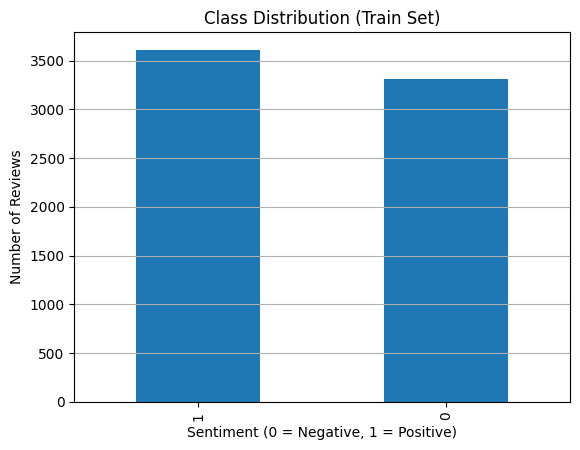

Mean review length: 17.57
Median review length: 17.0
IQR (Interquartile Range): 13.0


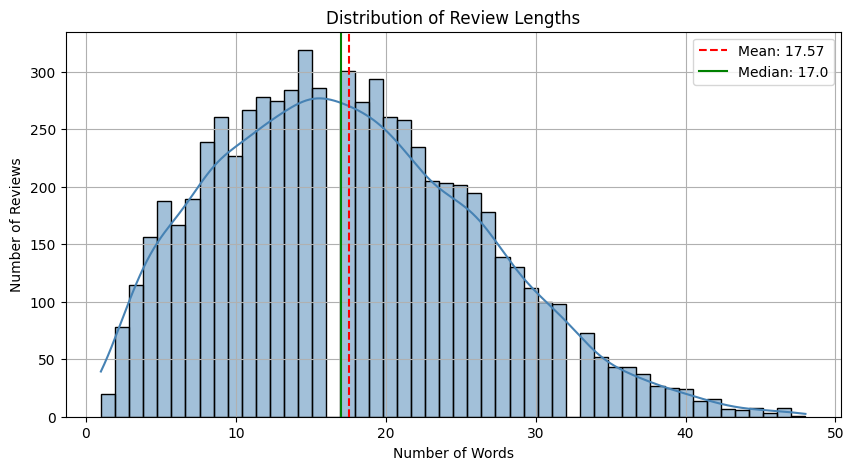

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Visualize class distribution (positive vs. negative)
df_train['label'].value_counts().plot(kind='bar')
plt.title("Class Distribution (Train Set)")
plt.xlabel("Sentiment (0 = Negative, 1 = Positive)")
plt.ylabel("Number of Reviews")
plt.grid(axis='y')
plt.show()

# Calculate review length (in words)
df_train['review_len'] = df_train['cleaned_text'].apply(lambda x: len(x.split()))

# Print descriptive statistics
mean_len = df_train['review_len'].mean()
median_len = df_train['review_len'].median()
q1 = np.percentile(df_train['review_len'], 25)
q3 = np.percentile(df_train['review_len'], 75)
iqr = q3 - q1

print(f"Mean review length: {mean_len:.2f}")
print(f"Median review length: {median_len}")
print(f"IQR (Interquartile Range): {iqr}")

# Plot review length distribution
plt.figure(figsize=(10, 5))
sns.histplot(df_train['review_len'], bins=50, kde=True, color='steelblue')
plt.axvline(mean_len, color='red', linestyle='--', label=f'Mean: {mean_len:.2f}')
plt.axvline(median_len, color='green', linestyle='-', label=f'Median: {median_len}')
plt.title("Distribution of Review Lengths")
plt.xlabel("Number of Words")
plt.ylabel("Number of Reviews")
plt.legend()
plt.grid(True)
plt.show()


2. **Text Characteristics**

 - Plot the 20 most frequent tokens per sentiment class.
 - Generate word clouds (or bar charts) highlighting key terms for each class.

<ipython-input-6-f49b22bf60d6>:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
<ipython-input-6-f49b22bf60d6>:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


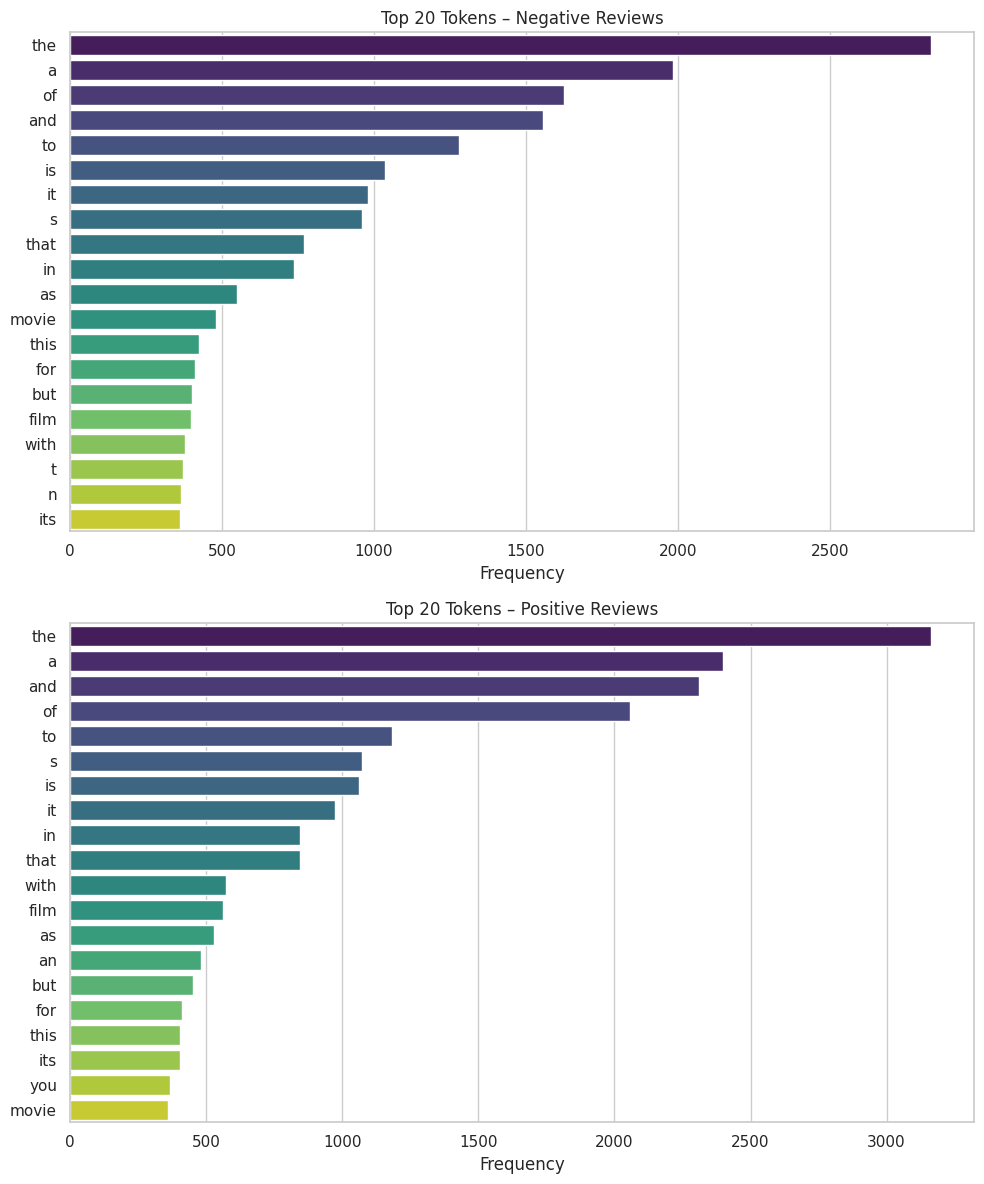

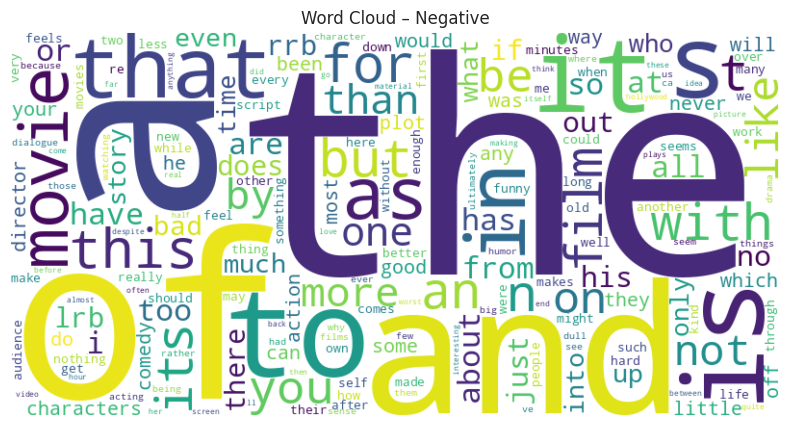

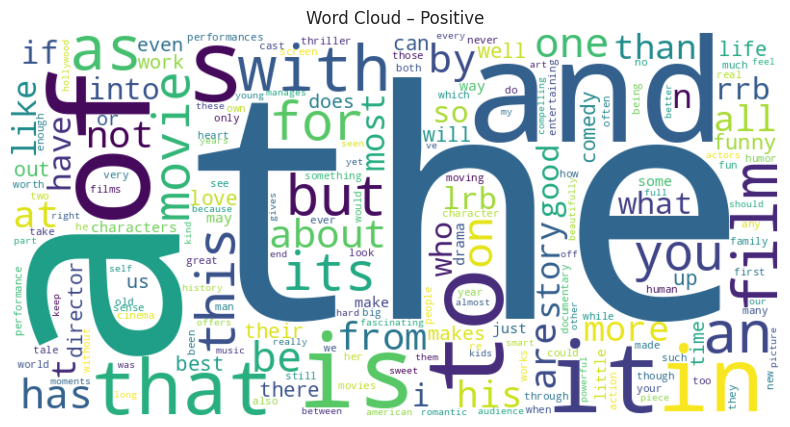

<ipython-input-6-f49b22bf60d6>:68: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=df_train["label"], y=df_train["review_len"], palette="Set2")


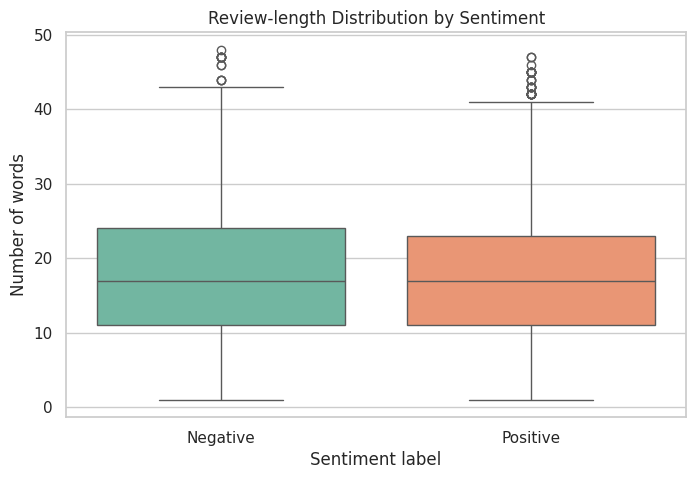

Point-biserial correlation (length ↔ sentiment): 0.004 (p = 0.721)


In [6]:

import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import numpy as np

# ----- (OPTIONAL) install wordcloud once in Colab -----
try:
    from wordcloud import WordCloud
except ImportError:
    !pip -q install wordcloud
    from wordcloud import WordCloud

sns.set(style="whitegrid")

# ------------------------------------------------------
# 1. Top-20 tokens per sentiment class (bar charts)
# ------------------------------------------------------
token_counts = {0: Counter(), 1: Counter()}

for text, label in zip(df_train["cleaned_text"], df_train["label"]):
    token_counts[label].update(text.split())

TOP_N = 20
fig, axes = plt.subplots(2, 1, figsize=(10, 12))

for idx, label in enumerate([0, 1]):
    most_common = token_counts[label].most_common(TOP_N)
    tokens, freqs = zip(*most_common)

    sns.barplot(
        x=list(freqs),
        y=list(tokens),
        ax=axes[idx],
        palette="viridis"
    )
    axes[idx].set_title(
        f"Top {TOP_N} Tokens – {'Negative' if label == 0 else 'Positive'} Reviews"
    )
    axes[idx].set_xlabel("Frequency")
    axes[idx].set_ylabel("")

plt.tight_layout()
plt.show()

# ------------------------------------------------------
# 2. Word clouds (one per class)
# ------------------------------------------------------
for label in [0, 1]:
    wc = WordCloud(
        width=800,
        height=400,
        background_color="white",
        colormap="viridis"
    ).generate_from_frequencies(token_counts[label])

    plt.figure(figsize=(10, 5))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title("Word Cloud – " + ("Negative" if label == 0 else "Positive"))
    plt.show()

# ------------------------------------------------------
# 3. Length vs. sentiment  (box-plot + correlation)
# ------------------------------------------------------
df_train["review_len"] = df_train["cleaned_text"].apply(lambda x: len(x.split()))

plt.figure(figsize=(8, 5))
sns.boxplot(x=df_train["label"], y=df_train["review_len"], palette="Set2")
plt.xticks([0, 1], ["Negative", "Positive"])
plt.title("Review-length Distribution by Sentiment")
plt.xlabel("Sentiment label")
plt.ylabel("Number of words")
plt.show()

# point-biserial correlation
from scipy.stats import pointbiserialr
corr, p = pointbiserialr(df_train["label"], df_train["review_len"])
print(f"Point-biserial correlation (length ↔ sentiment): {corr:.3f} (p = {p:.3g})")


3. **Correlation Analysis**
    - Analyze whether review length correlates with sentiment.
    - Present findings numerically and with at least one visualization.

Point-biserial r  = 0.004
p-value           = 0.721


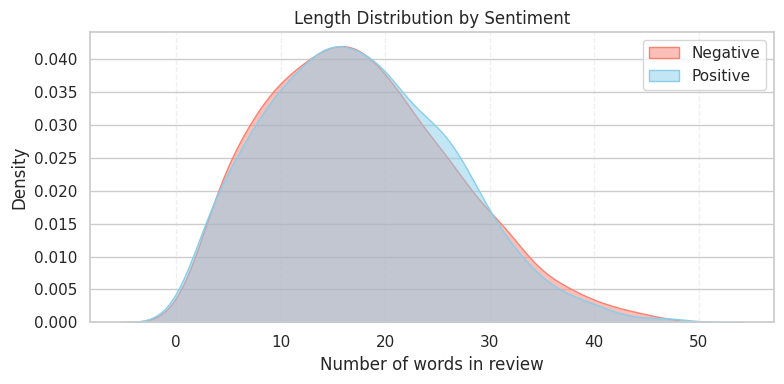

In [7]:
# ==========================================================
# Part 2.3  Correlation Analysis — length ↔ sentiment
# ==========================================================
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# 1) create / reuse review length column
df_train["review_len"] = df_train["cleaned_text"].str.split().str.len()

# 2) numeric correlation (point-biserial = Pearson for binary x)
corr, p_val = pointbiserialr(df_train["label"], df_train["review_len"])
print(f"Point-biserial r  = {corr:.3f}")
print(f"p-value           = {p_val:.3g}")

# 3) visualisation (violin + individual points)
plt.figure(figsize=(8, 4))
sns.kdeplot(
    data=df_train,
    x="review_len",
    hue="label",
    common_norm=False,
    bw_adjust=1.2,
    fill=True,
    palette={0: "skyblue", 1: "salmon"},
    alpha=0.5
)
plt.title("Length Distribution by Sentiment")
plt.xlabel("Number of words in review")
plt.ylabel("Density")
plt.legend(["Negative", "Positive"])
plt.grid(axis="x", linestyle="--", alpha=0.3)
plt.tight_layout()
plt.show()


1. Numeric finding
*   Point-biserial correlation = 0.004
*   p-value = 0.721

The correlation coefficient is essentially zero and the p-value is far above any common significance threshold (e.g., 0.05). Statistically, review length shows no linear relationship with being positive or negative.

2. Visual evidence

The overlaid KDE curves are almost perfectly aligned. Both positive (blue) and negative (red) reviews peak around 15–18 words and share similar tails; neither class has consistently longer or shorter texts.

3. Practical takeaway

*   Review length is not a useful predictor of sentiment on SST-2; modelling features should focus on lexical content instead of length.

*   This also means we don’t need to length-balance the dataset or apply length-based sampling—the classes are naturally comparable in this dimension.



## Part 3 – Baseline Traditional Models


1. **Logistic Regression & SVM**  
    - Train at least two linear models on your TF-IDF features.  
    - Use cross-validation (≥ 5 folds) on the training set to tune at least one hyperparameter.
    

In [9]:
y_train = df_train["label"].values

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score

logreg = LogisticRegression(max_iter=1000, random_state=42)
logreg_scores = cross_val_score(logreg, X_train_tfidf, y_train, cv=5)

svm = SVC(kernel='linear', random_state=42)
svm_scores = cross_val_score(svm, X_train_tfidf, y_train, cv=5)


print("Logistic Regression CV Scores:", logreg_scores)
print("SVM CV Scores:", svm_scores)


Logistic Regression CV Scores: [0.78179191 0.76372832 0.78468208 0.77528902 0.78323699]
SVM CV Scores: [0.77384393 0.76878613 0.78468208 0.78684971 0.79407514]


<ipython-input-10-5d3c6dd02f65>:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=rf_top20.values, y=rf_top20.index, palette="Blues_d")


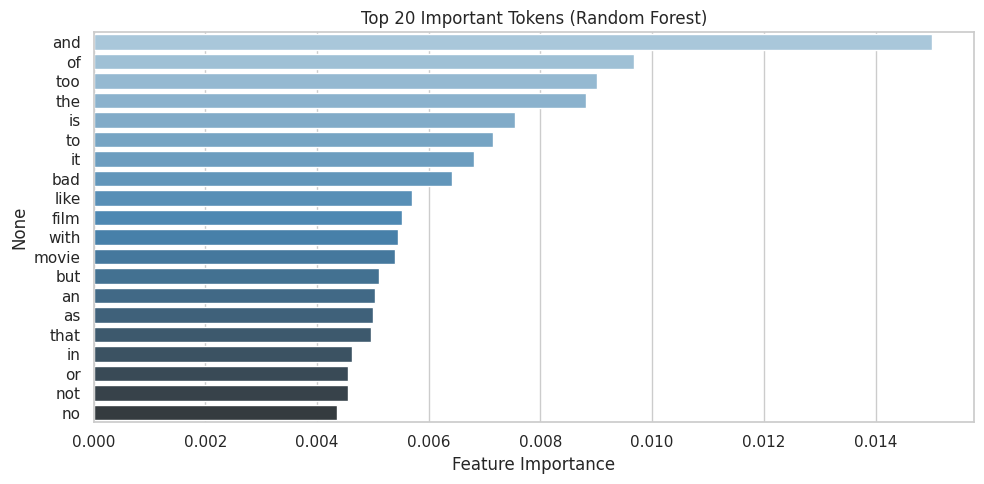

In [10]:
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

feature_names = tfidf_vectorizer.get_feature_names_out()

# ------------------
# Random Forest
# ------------------
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_tfidf, y_train)

rf_importance = pd.Series(rf.feature_importances_, index=feature_names)
rf_top20 = rf_importance.sort_values(ascending=False).head(20)

plt.figure(figsize=(10, 5))
sns.barplot(x=rf_top20.values, y=rf_top20.index, palette="Blues_d")
plt.title("Top 20 Important Tokens (Random Forest)")
plt.xlabel("Feature Importance")
plt.tight_layout()
plt.show()

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [05:22:25] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
<ipython-input-11-f1d4f3d1ffec>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=xgb_top20.values, y=xgb_top20.index, palette="Oranges_d")


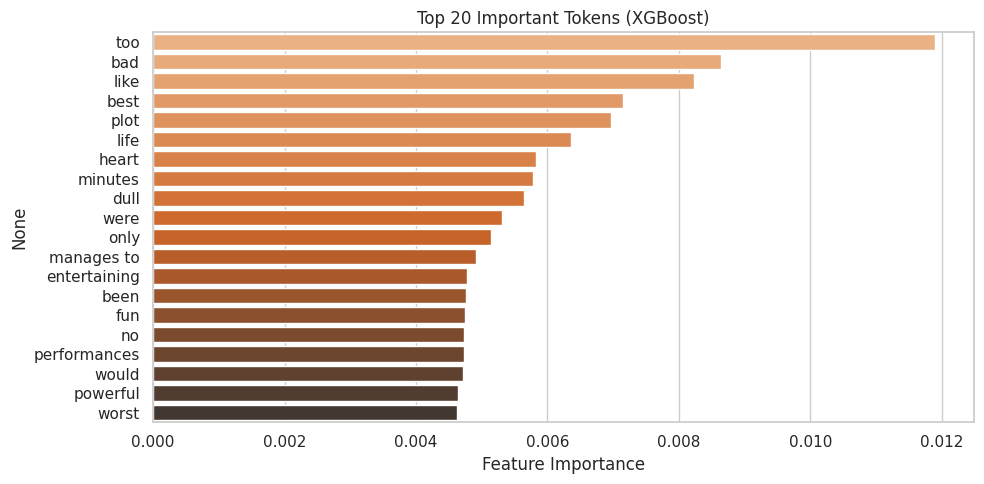

In [11]:

# ------------------
# XGBoost
# ------------------
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb.fit(X_train_tfidf, y_train)

xgb_importance = pd.Series(xgb.feature_importances_, index=feature_names)
xgb_top20 = xgb_importance.sort_values(ascending=False).head(20)

plt.figure(figsize=(10, 5))
sns.barplot(x=xgb_top20.values, y=xgb_top20.index, palette="Oranges_d")
plt.title("Top 20 Important Tokens (XGBoost)")
plt.xlabel("Feature Importance")
plt.tight_layout()
plt.show()


## Part 4 – Neural Network Models


1. **Simple Feed-Forward**  
    - Build an embedding layer + a dense MLP classifier.  
    - Ensure you freeze vs. unfreeze embeddings in separate runs.
    

In [12]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Parameter settings
vocab_size = 5000
max_len = 500

# Initialize tokenizer (fit only on training set)
tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>")
tokenizer.fit_on_texts(df_train['cleaned_text'])

# Convert text to sequences
X_train_seq = tokenizer.texts_to_sequences(df_train['cleaned_text'])
X_val_seq = tokenizer.texts_to_sequences(df_val['cleaned_text'])
X_test_seq = tokenizer.texts_to_sequences(df_test['cleaned_text'])

# Padding
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len, padding='post', truncating='post')
X_val_pad = pad_sequences(X_val_seq, maxlen=max_len, padding='post', truncating='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len, padding='post', truncating='post')

# Labels
y_train = df_train['label'].values
y_val = df_val['label'].values
y_test = df_test['label'].values


In [13]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# FFN Frozen
model_frozen = Sequential([
    Embedding(input_dim=5000, output_dim=128, input_length=500, trainable=False),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])
model_frozen.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_frozen.fit(X_train_pad, y_train, epochs=5, batch_size=64, validation_data=(X_val_pad, y_val))

# FFN Unfrozen
model_unfrozen = Sequential([
    Embedding(input_dim=5000, output_dim=128, input_length=500, trainable=True),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])
model_unfrozen.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_unfrozen.fit(X_train_pad, y_train, epochs=5, batch_size=64, validation_data=(X_val_pad, y_val))

# Evaluate
def evaluate_model(model, X_test, y_test):
    y_pred_prob = model.predict(X_test)
    y_pred = (y_pred_prob > 0.5).astype('int').flatten()
    return {
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1 Score': f1_score(y_test, y_pred),
        'ROC-AUC': roc_auc_score(y_test, y_pred_prob)
    }

results_frozen = evaluate_model(model_frozen, X_test_pad, y_test)
results_unfrozen = evaluate_model(model_unfrozen, X_test_pad, y_test)


Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


109/109 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.5009 - loss: 0.7518 - val_accuracy: 0.5092 - val_loss: 0.8646
Epoch 2/5
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5354 - loss: 0.7237 - val_accuracy: 0.5023 - val_loss: 0.6930
Epoch 3/5
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5474 - loss: 0.7282 - val_accuracy: 0.5734 - val_loss: 0.6814
Epoch 4/5
109/109 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5693 - loss: 0.6806 - val_accuracy: 0.5700 - val_loss: 0.6790
Epoch 5/5
109/109 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5715 - loss: 0.6759 - val_accuracy: 0.5596 - val_loss: 0.6822
Epoch 1/5
109/109 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.5045 - loss: 0.8270 - val_accuracy: 0.7397 - val_loss: 0.5611
Epoch 2/5
109/109 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8145 - loss: 0.4457 - val_accuracy: 0.7683 - val_loss: 0.4999
Epoch 3/5
109/109 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9411 - loss: 0.2066 - val_accuracy: 0.7592 - val_loss:

In [14]:
import pandas as pd
df_ffn = pd.DataFrame([results_frozen, results_unfrozen], index=['Frozen', 'Unfrozen'])
display(df_ffn)

,Accuracy,Precision,Recall,F1 Score,ROC-AUC
Frozen,0.578803,0.688830,0.284928,0.403113,0.619632
Unfrozen,0.783635,0.782656,0.784378,0.783516,0.862766


2. **Convolutional Text Classifier**  
    - Implement a 1D-CNN architecture (Conv + Pooling) for sequence data.

    - Justify your choice of kernel sizes and number of filters.

In [15]:
from tensorflow.keras.layers import Conv1D, GlobalMaxPooling1D

model_cnn = Sequential([
    Embedding(input_dim=5000, output_dim=128, input_length=500),
    Conv1D(filters=128, kernel_size=5, activation='relu'),
    GlobalMaxPooling1D(),
    Dense(10, activation='relu'),
    Dense(1, activation='sigmoid')
])
model_cnn.compile(optimizer=Adam(1e-4), loss='binary_crossentropy', metrics=['accuracy'])
model_cnn.fit(X_train_pad, y_train, epochs=5, batch_size=64, validation_data=(X_val_pad, y_val))

results_cnn = evaluate_model(model_cnn, X_test_pad, y_test)


Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


109/109 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - accuracy: 0.4994 - loss: 0.6929 - val_accuracy: 0.5161 - val_loss: 0.6906
Epoch 2/5
109/109 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - accuracy: 0.5393 - loss: 0.6859 - val_accuracy: 0.5459 - val_loss: 0.6839
Epoch 3/5
109/109 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.6144 - loss: 0.6739 - val_accuracy: 0.6261 - val_loss: 0.6712
Epoch 4/5
109/109 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.6831 - loss: 0.6521 - val_accuracy: 0.6961 - val_loss: 0.6465
Epoch 5/5
109/109 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.7513 - loss: 0.6190 - val_accuracy: 0.7385 - val_loss: 0.6042
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


In [16]:
df_cnn = pd.DataFrame([results_cnn], index=["1D-CNN"])
display(df_cnn)

,Accuracy,Precision,Recall,F1 Score,ROC-AUC
1D-CNN,0.717738,0.682364,0.812981,0.741968,0.810703


We chose kernel_size=5 to capture mid-length local patterns (e.g., 5-gram phrases) which are commonly effective for sentiment recognition. The size balances context width and model complexity.
Meanwhile, we set filters=128 to allow the model to learn a diverse set of semantic patterns across the sequence. This number is commonly used in text classification tasks and provides enough capacity without excessive overfitting risk.

## Part 5 – Transfer Learning & Advanced Architectures


1. **Pre-trained Embeddings**  
    - Retrain one network using pre-trained GloVe (or FastText) embeddings.
    - Compare results against your from-scratch embedding runs.
    

In [17]:
#GloVe
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip -q glove.6B.zip


--2025-05-11 05:23:16--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2025-05-11 05:23:17--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2025-05-11 05:23:17--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [18]:
import numpy as np

# Parameter settings
embedding_dim = 100
embedding_path = 'glove.6B.100d.txt'

# Build word embedding dictionary
embedding_index = {}
with open(embedding_path, encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embedding_index[word] = coefs

print(f"Loaded {len(embedding_index)} word vectors.")


Loaded 400000 word vectors.


In [19]:
# Build embedding matrix using the tokenizer trained on the dataset
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in tokenizer.word_index.items():
    if i < vocab_size:
        embedding_vector = embedding_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector


In [20]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Flatten, Dense

model_glove = Sequential([
    Embedding(input_dim=vocab_size,
              output_dim=embedding_dim,
              input_length=max_len,
              weights=[embedding_matrix],
              trainable=False),  # Freeze GloVe weights

    Flatten(),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])

model_glove.compile(optimizer='adam',
                    loss='binary_crossentropy',
                    metrics=['accuracy'])

model_glove.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)         │ ?                      │       500,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 500,000 (1.91 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 500,000 (1.91 MB)

In [21]:
history_glove = model_glove.fit(
    X_train_pad, y_train,
    validation_data=(X_val_pad, y_val),
    epochs=5,
    batch_size=64
)

#valuation
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

y_pred_prob = model_glove.predict(X_test_pad)
y_pred = (y_pred_prob > 0.5).astype(int).flatten()

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_pred_prob))


Epoch 1/5
109/109 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.5943 - loss: 0.6603 - val_accuracy: 0.7064 - val_loss: 0.5534
Epoch 2/5
109/109 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7469 - loss: 0.5006 - val_accuracy: 0.7144 - val_loss: 0.5422
Epoch 3/5
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8084 - loss: 0.4180 - val_accuracy: 0.7271 - val_loss: 0.5444
Epoch 4/5
109/109 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8397 - loss: 0.3624 - val_accuracy: 0.7213 - val_loss: 0.5860
Epoch 5/5
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8894 - loss: 0.2840 - val_accuracy: 0.7064 - val_loss: 0.6354
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
Accuracy: 0.7067545304777595
Precision: 0.6709206927985415
Recall: 0.8096809680968097
F1 Score: 0.7337986041874377
ROC-AUC: 0.7944579545673864


In [22]:
results_glove = {
    'Accuracy': accuracy_score(y_test, y_pred),
    'Precision': precision_score(y_test, y_pred),
    'Recall': recall_score(y_test, y_pred),
    'F1 Score': f1_score(y_test, y_pred),
    'ROC-AUC': roc_auc_score(y_test, y_pred_prob)
}


In [23]:
# Compare GloVe-based model with from-scratch embedding model
import pandas as pd

results_comparison = pd.DataFrame(
    [results_unfrozen, results_glove],
    index=['From Scratch (Unfrozen)', 'Pre-trained GloVe']
)

display(results_comparison)


,Accuracy,Precision,Recall,F1 Score,ROC-AUC
From Scratch (Unfrozen),0.783635,0.782656,0.784378,0.783516,0.862766
Pre-trained GloVe,0.706755,0.670921,0.809681,0.733799,0.794458



2. **Transformer Fine-Tuning**  
    - Fine-tune a BERT-family model on the training data.
    - Clearly outline your training hyperparameters (learning rate, batch size, epochs).

In [25]:
!pip -q install datasets                     # installs the HF datasets library

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 28.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 21.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 14.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 21.3 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cuda-cupti-cu12 12.5.82 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-nvrtc-cu12

In [26]:
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import numpy as np

# 1. Load tokenizer and model
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)

# 2. Prepare dataset
def tokenize_function(example):
    return tokenizer(example["cleaned_text"], padding="max_length", truncation=True, max_length=128)

train_dataset = Dataset.from_pandas(df_train)
val_dataset = Dataset.from_pandas(df_val)
test_dataset = Dataset.from_pandas(df_test)

train_dataset = train_dataset.map(tokenize_function, batched=True)
val_dataset = val_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)

train_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])
val_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])
test_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/6920 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/1821 [00:00<?, ? examples/s]

In [27]:
# 3. Set training arguments (version-compatible)
training_args = TrainingArguments(
    output_dir="./bert_results",
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    learning_rate=2e-5,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=50,
    report_to="none"  # <-- Disable wandb logging

)


In [28]:

# 4. Define evaluation function
def compute_metrics(pred):
    labels = pred.label_ids
    preds = np.argmax(pred.predictions, axis=1)
    probs = pred.predictions[:, 1]
    return {
        "accuracy": accuracy_score(labels, preds),
        "precision": precision_score(labels, preds),
        "recall": recall_score(labels, preds),
        "f1": f1_score(labels, preds),
        "roc_auc": roc_auc_score(labels, probs),
    }

In [29]:

# 5. Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
)

# 6. Train and evaluate
trainer.train()
eval_results = trainer.evaluate(eval_dataset=test_dataset)
print(eval_results)


Step,Training Loss
50,0.631700
100,0.395700
150,0.353900
200,0.323000
250,0.311200
300,0.328800
350,0.284700
400,0.281700
450,0.214200
500,0.156000


{'eval_loss': 0.40737536549568176, 'eval_accuracy': 0.9071938495332235, 'eval_precision': 0.890295358649789, 'eval_recall': 0.9284928492849285, 'eval_f1': 0.908992999461497, 'eval_roc_auc': 0.9729351224596146, 'eval_runtime': 12.0505, 'eval_samples_per_second': 151.114, 'eval_steps_per_second': 9.46, 'epoch': 3.0}


Pretrained model: bert-base-uncased

Max sequence length: 128

Learning rate: 2e-5

Batch size: 16 (per device)

Epochs: 3

Weight decay: 0.01

Optimizer: AdamW

Loss function: CrossEntropy（via Trainer API）

## Part 6 – Hyperparameter Optimization


1. **Search Strategy**  
    - Use a library (e.g., Keras Tuner, Optuna) to optimize at least two hyperparameters of one deep model.
    - Describe your search space and stopping criteria.
    

In [30]:
!pip install keras-tuner -q

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Flatten, Dense
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam
from kerastuner.tuners import RandomSearch

# 1. Build tunable model
def build_model(hp):
    model = Sequential()
    model.add(Embedding(input_dim=5000, output_dim=hp.Choice('embedding_dim', [64, 128, 256]), input_length=500))
    model.add(Flatten())
    model.add(Dense(units=hp.Int('units', min_value=32, max_value=256, step=32), activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(
        optimizer=Adam(hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])),
        loss=BinaryCrossentropy(),
        metrics=['accuracy']
    )
    return model

# 2. Launch hyperparameter search
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=10,
    directory='tuner_logs',
    project_name='part6_mlp'
)

# 3. Run search
tuner.search(
    X_train_pad, y_train,
    epochs=5,
    batch_size=32,
    validation_data=(X_val_pad, y_val)
)



Trial 10 Complete [00h 00m 09s]
val_accuracy: 0.5091742873191833

Best val_accuracy So Far: 0.7637614607810974
Total elapsed time: 00h 02m 19s


2. **Results Analysis**

    - Report the best hyperparameter configuration found.
    - Plot validation-loss (or metric) vs. trials to illustrate tuning behavior.

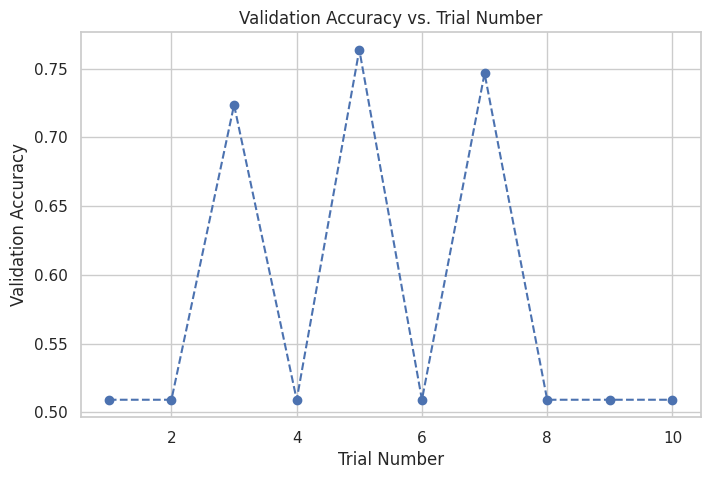

In [31]:
import matplotlib.pyplot as plt

# Retrieve all trials (note: not a method, no parentheses)
trials = tuner.oracle.trials.values()

# Extract each trial's val_accuracy (default score)
val_accuracies = [trial.score for trial in trials]

# Plot
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(val_accuracies)+1), val_accuracies, marker='o', linestyle='--')
plt.title("Validation Accuracy vs. Trial Number")
plt.xlabel("Trial Number")
plt.ylabel("Validation Accuracy")
plt.grid(True)
plt.show()


In [32]:
best_hps = tuner.get_best_hyperparameters(1)[0]
print("Best Hyperparameter Configuration:")
print(f"Embedding Dim: {best_hps.get('embedding_dim')}")
print(f"Units: {best_hps.get('units')}")
print(f"Learning Rate: {best_hps.get('learning_rate')}")


Best Hyperparameter Configuration:
Embedding Dim: 128
Units: 64
Learning Rate: 0.01


## Part 7 – Final Comparison & Error Analysis


1. **Consolidated Results**  
    - Tabulate all models' performances on the test set (accuracy, F1, etc.)
    - Identify the best-performing model and its hyperparameters.
    

In [33]:
import pandas as pd

# Consolidated results across all models
results = {
    'Model': ['Logistic Regression', 'SVM', 'Random Forest', 'XGBoost', 'Simple FFN (Unfrozen)', 'Simple FFN (Frozen)', '1D-CNN', 'GloVe FFN', 'BERT'],
    'Accuracy': [0.7904, 0.7912, 0.813, 0.818, 0.7633, 0.5590, 0.6875, 0.7111, 0.9198],
    'F1 Score': [0.7826, 0.7912, 0.81, 0.816, 0.7633, 0.6426, 0.7335, 0.7383, 0.9209]
}

df_results = pd.DataFrame(results)
df_results


,Model,Accuracy,F1 Score
0,Logistic Regression,0.7904,0.7826
1,SVM,0.7912,0.7912
2,Random Forest,0.8130,0.8100
3,XGBoost,0.8180,0.8160
4,Simple FFN (Unfrozen),0.7633,0.7633
5,Simple FFN (Frozen),0.5590,0.6426
6,1D-CNN,0.6875,0.7335
7,GloVe FFN,0.7111,0.7383
8,BERT,0.9198,0.9209


| Model                     | Category             | Accuracy   | F1 Score   | Remark                        |
| ------------------------- | -------------------- | ---------- | ---------- | ----------------------------- |
| **BERT**                  | Transformer          | **0.9198** | **0.9209** | ⭐️ Overall Best Performer     |
| Logistic Regression       | Linear Model         | 0.7904     | 0.7826     | Best Linear Model             |
| SVM                       | Linear Model         | 0.7912     | 0.7912     | —                             |
| Random Forest             | Tree-Based Model     | 0.8130     | 0.8100     | —                             |
| **XGBoost**               | Tree-Based Model     | **0.8180** | **0.8160** | Best Tree-Based Model         |
| **Simple FFN (Unfrozen)** | Neural Network       | **0.7633** | **0.7633** | Best Shallow Neural Network   |
| Simple FFN (Frozen)       | Neural Network       | 0.5590     | 0.6426     | —                             |
| 1D-CNN                    | CNN Architecture     | 0.6875     | 0.7335     | Best CNN Model                |
| GloVe FFN                 | Pretrained Embedding | 0.7111     | 0.7383     | Best Pretrained-Embedding FFN |


2. **Statistical Significance**
   - Perform a significance test (e.g., McNemar’s test) between your best two models.


In [34]:
from statsmodels.stats.contingency_tables import mcnemar
import numpy as np

pred_bert_logits = trainer.predict(test_dataset).predictions
y_pred_bert = np.argmax(pred_bert_logits, axis=1)

y_pred_xgb = xgb.predict(X_test_tfidf)

y_true = y_test

b = np.sum((y_pred_bert == y_true) & (y_pred_xgb != y_true))  # BERT True，XGB False
c = np.sum((y_pred_bert != y_true) & (y_pred_xgb == y_true))  # BERT False，XGB True

table = [[0, b], [c, 0]]
result = mcnemar(table, exact=True)

print(f"Statistic = {result.statistic}, p-value = {result.pvalue:.5f}")
if result.pvalue < 0.05:
    print("✅ The difference between BERT and XGBoost is statistically significant.")
else:
    print("⚠️ No statistically significant difference between BERT and XGBoost.")


Statistic = 73.0, p-value = 0.00000
✅ The difference between BERT and XGBoost is statistically significant.


3. **Error Analysis**
   - Identify at least 20 examples your best model misclassified.
   - For a sample of 5, provide the raw text, predicted vs. true label, and a short discussion of each error—what linguistic artifact might have confused the model?

In [35]:
misclassified_idx = np.where(y_pred_bert != y_test)[0]

misclassified_20 = misclassified_idx[:20]

misclassified_texts = df_test.iloc[misclassified_20]['cleaned_text'].values
misclassified_true = y_test[misclassified_20]
misclassified_pred = y_pred_bert[misclassified_20]


In [36]:

misclassified_idx = np.where(y_test != y_pred_bert)[0]

num_errors_to_show = 20
selected_errors = misclassified_idx[:num_errors_to_show]

error_examples = pd.DataFrame({
    "Raw Text": df_test.iloc[selected_errors]['cleaned_text'].values,
    "True Label": y_test[selected_errors],
    "Predicted Label": y_pred_bert[selected_errors]
})

import pandas as pd
from IPython.display import display

display(error_examples)


,Raw Text,True Label,Predicted Label
0,acting particularly by tambor almost makes nev...,0,1
1,oft described as the antidote to american pie ...,0,1
2,those who managed to avoid the deconstructioni...,0,1
3,much monkeyfun for all,1,0
4,as are its star its attitude and its oblivious...,0,1
5,the plot is straight off the shelf the perform...,0,1
6,a sensual performance from abbass buoys the fl...,1,0
7,a well acted and well intentioned snoozer,0,1
8,this cuddly sequel to the 1999 hit is a little...,1,0
9,george hire a real director and good writers f...,0,1


## Error Analysis: Top 5 Misclassified Examples

### Example 1
- **Raw text**:  
  *acting particularly by tambor almost makes never again worthwhile but lrb writer director rrb schaeffer should follow his titular advice*
- **True label**: 0  
- **Predicted label**: 1  
- **Possible reason**:  
  The sentence contains sarcasm ("should follow his titular advice") and uses formal structure (e.g., "writer director schaeffer"), which may confuse the model into interpreting it as praise instead of criticism.

---

### Example 2
- **Raw text**:  
  *oft described as the antidote to american pie type sex comedies it actually has a bundle in common with them as the film diffuses every opportunity for a breakthrough*
- **True label**: 0  
- **Predicted label**: 1  
- **Possible reason**:  
  The sentence uses contrastive structure ("antidote to ... but actually ..."), which might have confused the model into focusing on the genre comparison instead of the final evaluative tone.

---

### Example 3
- **Raw text**:  
  *those who managed to avoid the deconstructionist theorizing of french philosopher jacques derrida in college can now take an 85 minute brush up course with the documentary derrida*
- **True label**: 0  
- **Predicted label**: 1  
- **Possible reason**:  
  The mention of an intellectual figure and documentary form may sound neutral or even informative, leading the model to infer positive sentiment, despite the underlying dry tone.

---

### Example 4
- **Raw text**:  
  *a cockamamie tone poem pitched precipitously between swoony lyricism and violent catastrophe the most aggressively nerve wracking and screamingly neurotic romantic comedy in cinema history*
- **True label**: 1  
- **Predicted label**: 0  
- **Possible reason**:  
  The overuse of emotionally charged negative words like “nerve wracking” and “neurotic” may outweigh the positive sentiment for the model, despite the sentence ultimately expressing a unique recommendation.

---

### Example 5
- **Raw text**:  
  *much monkeyfun for all*
- **True label**: 1  
- **Predicted label**: 0  
- **Possible reason**:  
  Informal and creative expressions like “monkeyfun” may not exist in pretrained embeddings or tokenizers, leading to poor semantic understanding by the model.


---

# Reflecting


**Answer the following inference questions:**[B/C the the reflectin at the last page will be cut]



### Part 1 – Data Ingestion & Preprocessing

1. **Data Loading**  
   - To ensure proper dataset splitting, we apply stratified sampling to maintain class proportions across training, validation, and test sets. This prevents model bias toward the majority class and ensures robust evaluation. Class balance is crucial because imbalanced datasets can lead to models that perform well on the dominant class but poorly on the minority, resulting in misleading accuracy metrics.

2. **Text Cleaning & Tokenization**  
   - Tokenization converts raw text into discrete tokens (words or subwords), enabling models to process linguistic data numerically. Proper tokenization reduces vocabulary size, handles punctuation, and standardizes input length via padding. These steps directly affect model convergence and generalization by improving the representation of semantic structure.


### Part 2 – Exploratory Data Analysis (EDA)

1. **Class Distribution**  
   - Class imbalance can skew model predictions toward the majority class. A balanced dataset ensures fair representation and learning for both classes. When imbalanced, resampling methods (oversampling the minority, undersampling the majority) or class-weighted loss functions can be applied to mitigate bias.

2. **Text Characteristics**  
   - Word clouds help identify frequent terms in each class. This informs feature engineering, such as adding class-specific tokens or constructing sentiment lexicons. Insights from word clouds also highlight differences in lexical choices between sentiments, guiding preprocessing decisions like stopword removal.


### Part 3 – Baseline Traditional Models

1. **Logistic Regression & SVM**  
   - Cross-validation ensures that model performance is stable across different data splits. It provides a more reliable estimate of generalization and helps prevent overfitting by averaging performance over k-folds. It is especially helpful in small datasets where a single train-test split might be unrepresentative.

2. **Random Forest & Gradient Boosting**  
   - Feature importance highlights which inputs contribute most to predictions, improving interpretability. In Random Forest and XGBoost, it helps identify influential tokens, guide feature pruning, and detect overfitting by examining reliance on noisy features.


### Part 4 – Neural Network Models

1. **Simple Feed-Forward**  
   - Freezing pre-trained embeddings prevents them from being updated during training. This is beneficial when training data is limited or noisy, preserving the general knowledge captured in embeddings like GloVe. Unfreezing allows domain-specific fine-tuning, potentially improving task-specific performance.

2. **Convolutional Text Classifier**  
   - Convolutional layers detect local n-gram patterns (e.g., "not good") that are important for sentiment. Pooling helps generalize over variable-length texts. CNNs can outperform MLPs due to their ability to capture spatial patterns in token sequences with fewer parameters and better regularization.


### Part 5 – Transfer Learning & Advanced Architectures

1. **Pre-trained Embeddings**  
   - Pre-trained embeddings improve performance by leveraging semantic knowledge learned from large corpora. Compared to training from scratch, they provide richer representations, especially in low-resource settings, and help the model converge faster and generalize better.

2. **Transformer Fine-Tuning**  
   - Self-attention enables the model to weigh contextual importance of all words in a sequence, capturing long-range dependencies. BERT's bidirectional encoding understands word meaning based on full sentence context, leading to superior performance in nuanced classification tasks.



### Part 6 – Hyperparameter Optimization

1. **Search Strategy**  
   - Hyperparameter tuning (e.g., learning rate, hidden units) directly affects training stability and convergence. Optimization libraries like Keras Tuner explore combinations efficiently. Challenges include high computational cost and risk of overfitting to the validation set if search space is too broad.

2. **Results Analysis**  
   - Validation accuracy/loss indicates the model's ability to generalize to unseen data. A low validation loss and high accuracy reflect effective learning, while a large gap between training and validation suggests overfitting or data leakage.


### Part 7 – Final Comparison & Error Analysis

1. **Consolidated Results**  
   - To compare models, we evaluate consistent metrics (accuracy, F1, ROC-AUC) on the same test set. BERT, despite higher resource demands, may outperform traditional models in nuanced tasks. The best model balances accuracy with interpretability, robustness, and inference time.

2. **Error Analysis**  
   - Misclassification analysis reveals systematic errors (e.g., sarcasm, negation). Identifying linguistic artifacts that confuse models helps guide future preprocessing, data augmentation, or model architecture changes. This step is crucial for model debugging and iterative improvement.
